# Room Occupancy prediction

<p>I downloaded the Occupancy Detection Data Set from https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+ </a> </p> <p>The data is described as follows: </p>
<p>Three data sets are submitted, for training and testing. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute. </p>
<p>With the following attribute info:
<ul> <li>date time year-month-day hour:minute:second</li>
<li>Temperature, in Celsius </li>
<li>Relative Humidity, %</li>
<li>Light, in Lux</li>
<li> CO2, in ppm</li>
<li> Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air</li>
<li>Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status</li>
   </ul></p>

In [1]:
from zipfile import ZipFile

In [2]:
zipf = ZipFile("occupancy_data.zip", 'r')
zipf.printdir()

File Name                                             Modified             Size
datatest.txt                                   2016-01-05 15:51:24       200766
datatest2.txt                                  2016-01-05 15:51:24       699664
datatraining.txt                               2016-01-05 15:51:24       596674


So, we see that the zip archive has got three files in a *.txt format. Now, I'll extract all the three files and import them.

In [3]:
zipf.extractall()

In [4]:
zipf.close()

In [5]:
import pandas as pd 
import numpy as np

First of all, I would like to see the format of these files, because I'm not sure they're in a proper *.csv format. 

In [6]:
with open("datatraining.txt",'r') as file:
    print(file.readlines()[:2])

['"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"\n', '"1","2015-02-04 17:51:00",23.18,27.272,426,721.25,0.00479298817650529,1\n']


In [7]:
with open("datatest.txt",'r') as file:
    print(file.readlines()[:2])

['"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"\n', '"140","2015-02-02 14:19:00",23.7,26.272,585.2,749.2,0.00476416302416414,1\n']


In [8]:
with open("datatest2.txt",'r') as file:
    print(file.readlines()[:5])

['"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"\n', '"1",2015-02-11 14:48:00,21.76,31.1333333333333,437.333333333333,1029.66666666667,0.00502101089021385,1\n', '"2",2015-02-11 14:49:00,21.79,31,437.333333333333,1000,0.00500858127480172,1\n', '"3",2015-02-11 14:50:00,21.7675,31.1225,434,1003.75,0.0050215691326541,1\n', '"4",2015-02-11 14:51:00,21.7675,31.1225,439,1009.5,0.0050215691326541,1\n']


Ok, so the format is the same for all the three files. Good to know. Let's try and import the data with Pandas.

In [9]:
train_df = pd.read_csv("datatraining.txt")

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
date             8143 non-null object
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


First thing to do is to change the data type of 'date' to datetime, and to set it as index.

In [11]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df=train_df.set_index('date')

In [12]:
train_df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [13]:
#and..
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 6 columns):
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null int64
dtypes: float64(5), int64(1)
memory usage: 445.3 KB


And we see that the datetime index is correctly in place, and also the memory usage has reduced. This is not particularly useful here but it can make the difference with a high number of features and instances.<br> Now, I'll change also the Occupancy to categorical.

In [14]:
train_df['Occupancy'] = train_df['Occupancy'].astype('category')

# Explorative Analysis

As a first step, let's check the presence of missing values in the features.

In [15]:
print("Missing values check:")
for feature in train_df.columns:
    mis_perc = train_df[feature].isna().sum() * 100 / len(train_df)
    print(feature + " has {} % of missing values".format(mis_perc))

Missing values check:
Temperature has 0.0 % of missing values
Humidity has 0.0 % of missing values
Light has 0.0 % of missing values
CO2 has 0.0 % of missing values
HumidityRatio has 0.0 % of missing values
Occupancy has 0.0 % of missing values


Now, some statistics about the features:

In [16]:
train_df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863
std,1.016916,5.531211,194.755805,314.320877,0.000852
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,19.700000,20.200000,0.000000,439.000000,0.003078
50%,20.390000,26.222500,0.000000,453.500000,0.003801
75%,21.390000,30.533333,256.375000,638.833333,0.004352
max,23.180000,39.117500,1546.333333,2028.500000,0.006476


The data seems to be in reasonable range. Now I'll do some plots of the numerical features to see distributions and time-based plots.

## Plotting numerical variables

In [17]:
import matplotlib.pyplot as plt 

C:\Users\Andrea\Anaconda3\envs\py36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


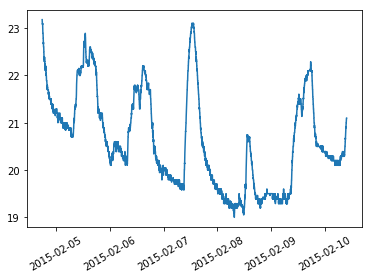

In [18]:
plt.plot(train_df['Temperature'])
plt.xticks(rotation='30')
plt.show()

Now, a quick way to check the distribution of values of Temperature:

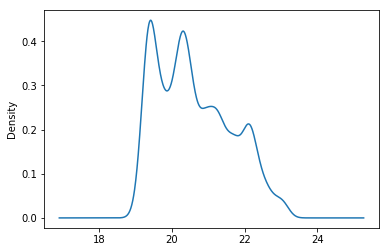

In [19]:
train_df['Temperature'].plot(kind='kde')

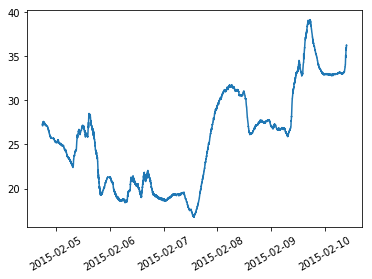

In [20]:
plt.plot(train_df['Humidity'])
plt.xticks(rotation='30')
plt.show()

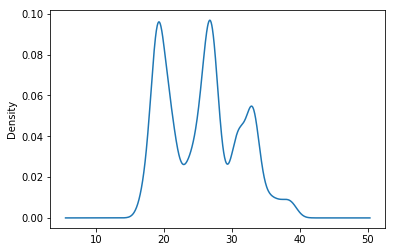

In [21]:
train_df['Humidity'].plot(kind='kde')

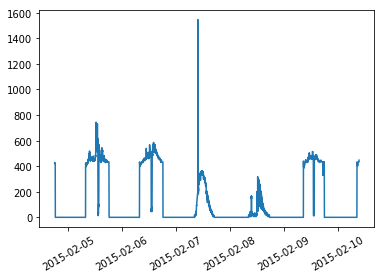

In [22]:
plt.plot(train_df['Light'])
plt.xticks(rotation='30')
plt.show()

The light sensor seems to provide exactly the interval of time where the room was occupied, so it must be an important variable for telling if the room is occupied or not. The distribution should be almost normal?

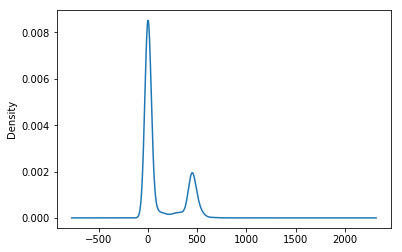

In [23]:
train_df['Light'].plot(kind='kde')

Almost correct! These two peaks show that the values 0 and about 500 are related to OFF-ON on the lighting. Very interesting.

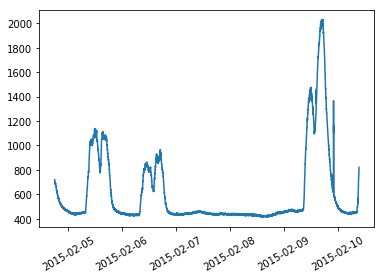

In [24]:
plt.plot(train_df['CO2'])
plt.xticks(rotation='30')
plt.show()

CO2 plot shows also presence of a person in the room. What about the distribution?

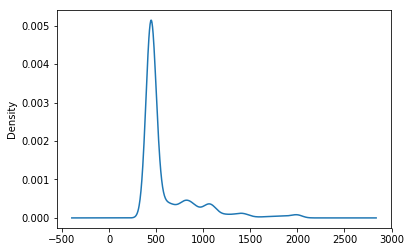

In [25]:
train_df['CO2'].plot(kind='kde')

Nothing special.

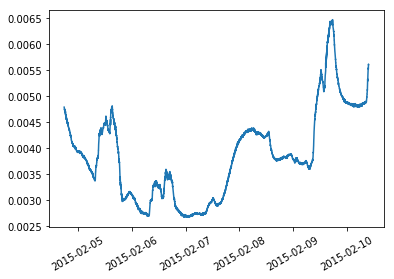

In [26]:
plt.plot(train_df['HumidityRatio'])
plt.xticks(rotation='30')
plt.show()

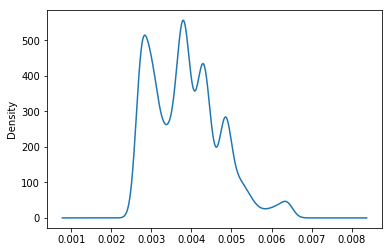

In [27]:
train_df['HumidityRatio'].plot(kind='kde')

The HumidityRatio seems very similar one to the other. Hopefully I'll discover some linear correlation between the two.

### Correlation between numerical features

As a first thing, I would immediately check any correlation between Humidity and HumidityRatio together with Temperature.

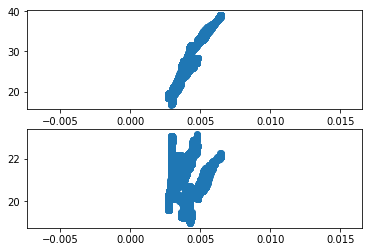

In [28]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.scatter(train_df['HumidityRatio'],train_df['Humidity'])
ax2.scatter(train_df['HumidityRatio'],train_df['Temperature'])

There is obviously correlation between HumidityRatio and Humidity, and also some type of correlation between HumidityRatio and Temperature. I'll try by getting my own humidity/ temperature ratio and compare it with the provided one.

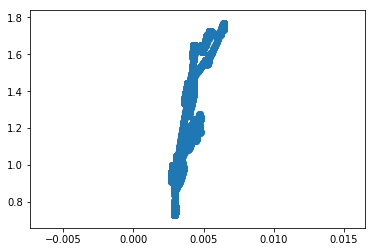

In [29]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(train_df['HumidityRatio'],train_df['Humidity']/train_df['Temperature'])

As expected, there is a clear trend between these two. And what about the time plot of the new feature?

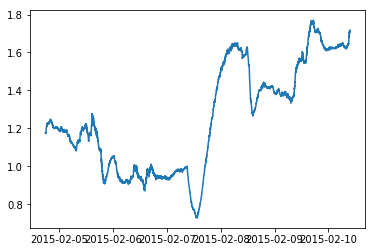

In [30]:
plt.plot(train_df['Humidity']/train_df['Temperature'])

Same shape, again! Nice to know. 

### Analysis of target variable and correlation between features

Let's print again the features just not to continuously scroll the page back and forth :D

In [31]:
train_df.columns

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

Given the low number of features, I can easily plot pairplots using Seaborn.

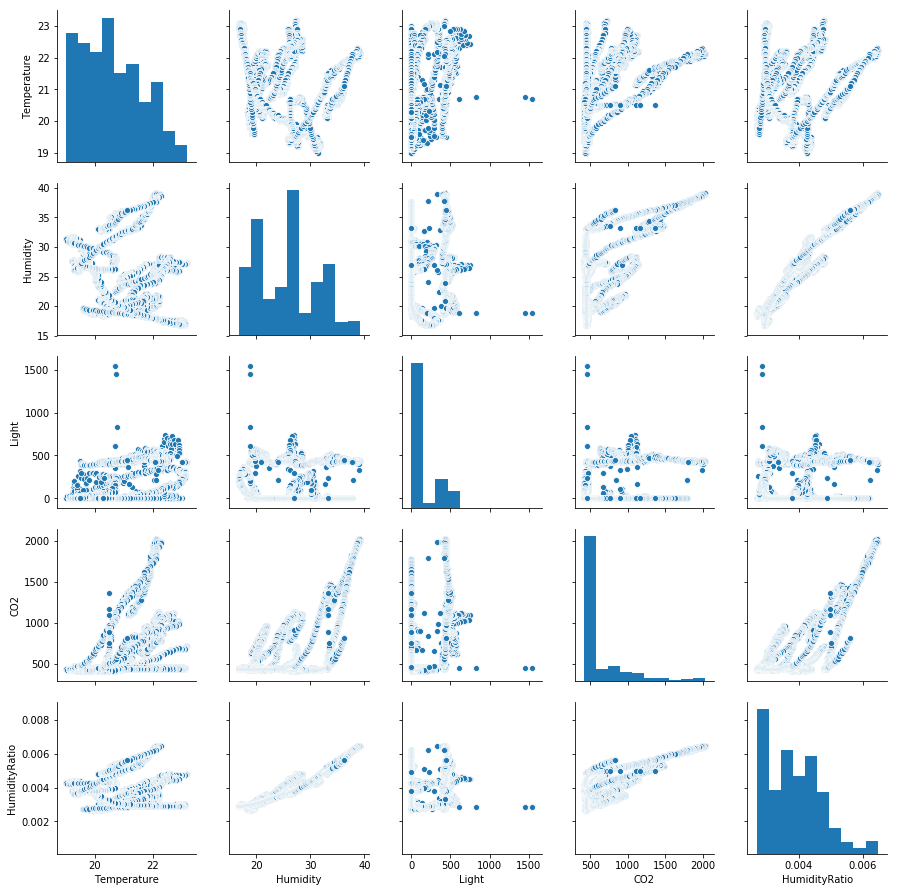

In [32]:
import seaborn as sb 
sb.pairplot(train_df.drop('Occupancy', axis=1))

In general, there seems to be a linear correlation between all variables; of course it is to be made clear that these are time series, so the scatterplots are a bit messy but let us understand the correlation.

**Pearson Correlation**

Now, let's see the Pearson correlation between the variables.

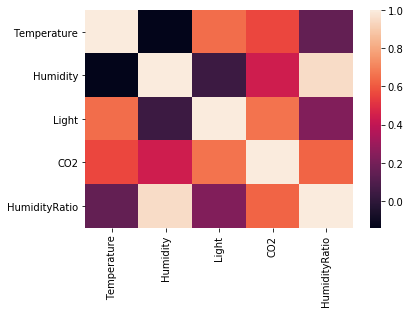

In [33]:
sb.heatmap(train_df.drop('Occupancy',axis=1).corr())

The plot seems to reveal what already said; in general all the variables are correlated, and of course correlation of the HumidityRatio with the other variables is half-way between the one of Temperature and Humidity. I could even think of dropping HumidityRatio. Another possible alternative could be removing both Temperature and Humidity, and only keep HumidityRatio, which is correlated with all variables.

In [34]:
train_df = train_df.drop('HumidityRatio', axis=1)

In [35]:
train_df['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

Just to make it clear, 0 is representing not-occupied whereas 1 is representing occupied. I'll try to keep the data as is, even if the target variable is not balanced.

### Model creation

I will first fit a Logistic Regression to this data, and possibly I'll move on to more complex models. In my journey through statistics and engineering, I understood that simpler things are simpler to comprehend and to explain.

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
log_reg = LogisticRegression()

Of course, I forgot to mention that I will not split the data as it is already splitted in training and test sets.

In [38]:
X_train, y_train = train_df.drop('Occupancy', axis=1), train_df.iloc[:,-1]

Quick check:

In [39]:
X_train.head()

,Temperature,Humidity,Light,CO2
date,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50


In [40]:
y_train.head()

date
2015-02-04 17:51:00    1
2015-02-04 17:51:59    1
2015-02-04 17:53:00    1
2015-02-04 17:54:00    1
2015-02-04 17:55:00    1
Name: Occupancy, dtype: category
Categories (2, int64): [0, 1]

Also, I will scale the data on-the-go, in order to have same magnitudes to interpret logit coefficients.

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)

In [42]:
Xs_train[:3]

array([[2.51847007, 0.27852622, 1.57376283, 0.36494808],
       [2.48896731, 0.27771261, 1.59173515, 0.34188106],
       [2.48896731, 0.27364453, 1.57376283, 0.34029023]])

In [43]:
log_reg.fit(Xs_train, y_train)

C:\Users\Andrea\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
log_reg.coef_

array([[-1.34990992, -0.20622622,  3.83722684,  1.86440882]])

Light and CO2 seem to be covariates that tell a lot about occupancy of the room! So, light on and a person breathing heavily are symptoms of an occupied room.

In [45]:
log_reg.score(Xs_train,y_train)

0.9860002456097261

So, the model performs well on the training set, but the real score is to be calculated on the test sets.

### Model evaluation on Test sets

I will import the first test dataset. In order to avoid scaling data each time, I will build a simple helper function.

In [46]:
def scale_predict(data):
    train = data.drop('Occupancy', axis=1)
    target = data['Occupancy']
    scaler = StandardScaler()
    train= scaler.fit_transform(train)
    return log_reg.predict(train)

In [47]:
test1_df = pd.read_csv("datatest.txt")
test1_df['date'] = pd.to_datetime(test1_df['date'])
test1_df=test1_df.set_index('date')
test1_df['Occupancy'] = test1_df['Occupancy'].astype('category')
test1_df = test1_df.drop('HumidityRatio', axis=1)

Ready to test :D 

In [48]:
predictions1 = scale_predict(test1_df)
target1 = test1_df['Occupancy']

In [49]:
from sklearn.metrics import accuracy_score

In [50]:
print(accuracy_score(target1,predictions1))

0.8900562851782364


Not bad, of course one could try and do better! Second test now.

In [51]:
test2_df = pd.read_csv("datatest2.txt")
test2_df['date'] = pd.to_datetime(test2_df['date'])
test2_df=test2_df.set_index('date')
test2_df['Occupancy'] = test2_df['Occupancy'].astype('category')
test2_df = test2_df.drop('HumidityRatio', axis=1)

In [52]:
predictions2 = scale_predict(test2_df)
target2 = test2_df['Occupancy']

In [53]:
print(accuracy_score(target2,predictions2))

0.9597005742411813


Let's see the balance of the target variables in both test sets.

In [54]:
test1_df['Occupancy'].value_counts()

0    1693
1     972
Name: Occupancy, dtype: int64

In [55]:
test2_df['Occupancy'].value_counts()

0    7703
1    2049
Name: Occupancy, dtype: int64

In [56]:
## Same thing for train_set 
train_df['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

We get higher results on the second test set, which has a distribution of targets similar to the train set. Maybe the logit has learned in a biased way towards the 0 prediction? I will see the confusion matrix to validate the thing.

In [57]:
from sklearn.metrics import confusion_matrix

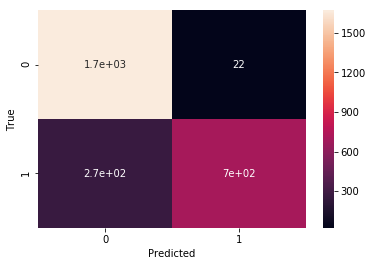

In [58]:
plt.figure()
sb.heatmap(confusion_matrix(target1,predictions1), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

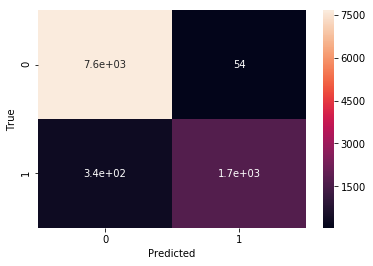

In [59]:
plt.figure()
sb.heatmap(confusion_matrix(target2,predictions2), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As expected, the classifier is biased towards predicting 0's. I should resample the train data in order to have a balance between classes.